# Import Libraries

In [1]:
%%capture
!pip install pyDOE

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from pyDOE import lhs
import matplotlib.pyplot as plt
from torch.utils.checkpoint import checkpoint

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

if device == 'cuda': print(torch.cuda.get_device_name())

cuda


# Physics Informed Neural Network

In [3]:
class PINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the Gross-Pitaevskii equation (GPE).

    Attributes
    ----------
    layers : nn.ModuleList
        List of neural network layers.
    ub : torch.Tensor
        Upper bound for input normalization.
    lb : torch.Tensor
        Lower bound for input normalization.
    adaptive_bc_scale : torch.nn.Parameter
        Learnable scaling factor for boundary condition loss.
    hbar : torch.nn.Parameter
        Learnable or fixed parameter for Planck's constant.
    m : torch.nn.Parameter
        Learnable parameter for particle mass.
    g : torch.nn.Parameter
        Learnable parameter for interaction strength.
    """

    def __init__(self, layers, ub, lb, hbar=1.0, m=1.0, g=1.0):
        """
        Initializes the PINN model with given layer sizes and boundary conditions.

        Parameters
        ----------
        layers : list
            List of integers specifying the number of units in each layer.
        ub : list or numpy.ndarray
            Upper bounds of the input domain for feature normalization.
        lb : list or numpy.ndarray
            Lower bounds of the input domain for feature normalization.
        hbar : float, optional
            Planck's constant, default is the physical value in J⋅Hz−1.
        m : float
            Particle mass, scaled is 1.0.
        g : float
            Interaction strength, scaled is 1.0.
        """
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.ub = torch.tensor(ub, dtype=torch.float32, device=device)
        self.lb = torch.tensor(lb, dtype=torch.float32, device=device)

        self.adaptive_bc_scale = nn.Parameter(torch.tensor(1.0, device=device))  # Adaptive weighting for BC loss (lambda)
        self.hbar = hbar  # Planck's constant (fixed or learnable?)
        self.m = m # Particle mass (fixed)
        self.g = g # Interaction strength (fixed)

        # Define network layers
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.layers.append(nn.LeakyReLU())

        self.activation = nn.LeakyReLU() # Use other activation function? Sine?
        self.init_weights()

    def init_weights(self):
        """ Initialize weights using Xavier initialization. """
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)

    def forward(self, x):
        """
        Forward pass through the neural network.

        Parameters
        ----------
        x : torch.Tensor
            Input tensor for the neural network.

        Returns
        -------
        torch.Tensor
            Output of the neural network after forward pass.
        """

        # Ensure lb and ub are broadcastable to the shape of x
        lb = self.lb.view(1, -1)  # Ensure lb shape is (1, num_features)
        ub = self.ub.view(1, -1)  # Ensure ub shape is (1, num_features)

        # Normalize the inputs
        x = (x - lb) / (ub - lb)

        # Use gradient checkpointing for layers to save memory
        for i, layer in enumerate(self.layers):
            if i % 2 == 0:  # Apply checkpointing only to Linear layers
                x = checkpoint(layer, x, use_reentrant=False)
            else:
                x = layer(x)

        return x

    def test(self, num_grid_pts):
        """
        Tests the model on the test data and computes the relative L2 norm of the error.

        Parameters
        ----------
        num_grid_pts : torch.Tensor
            Input tensor for the number of grid points.

        Returns
        -------
        error_vec : torch.Tensor
            The relative L2 norm of the error.
        u_pred : numpy.ndarray
            The predicted output reshaped as a 2D array.
        """
        # Model prediction on test data
        u_pred = self.forward(X_u_test_tensor)

        # Compute relative L2 norm of the error
        error_vec = torch.linalg.norm((u - u_pred), 2) / (torch.linalg.norm(u, 2) + 1e-2) # Scale if dividing by zeros

        # Reshape the predicted output to a 2D array
        u_pred = np.reshape(u_pred.cpu().detach().numpy(), (num_grid_pts, num_grid_pts), order='F')

        return error_vec, u_pred

    def loss_BC(self, x_bc, y_bc):
        """
        Computes the boundary condition (BC) loss.

        Parameters
        ----------
        x_bc : torch.Tensor
            Boundary condition input data.
        y_bc : torch.Tensor
            Boundary condition output (true) values.

        Returns
        -------
        torch.Tensor
            Scaled mean squared error (MSE) loss for boundary conditions.
        """
        u_pred = self.forward(x_bc)
        y_bc = torch.zeros_like(y_bc) # Convert this into a torch array of zeros
        adaptive_scale = self.adaptive_bc_scale  # Adaptive scaling
        bc_loss = adaptive_scale * torch.mean((u_pred - y_bc) ** 2)

        # TODO: Make u_pred zero only at the boundary
        # Look at (and replicate) prepare_training_data in helmholtz_2.py
        return bc_loss

    def riesz_loss(self, predictions, inputs):
        """
        Computes the Riesz energy loss for regularization.

        Parameters
        ----------
        predictions : torch.Tensor
            Model predictions.
        inputs : torch.Tensor
            Input points.

        Returns
        -------
        torch.Tensor
            Riesz energy loss.
        """

        psi = predictions

        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)
        gradients = torch.autograd.grad(outputs=predictions, inputs=inputs,
                                        grad_outputs=torch.ones_like(predictions),
                                        create_graph=True, retain_graph=True)[0]
        # riesz_energy = torch.sum(gradients ** 2)
        riesz_energy = torch.sum(gradients ** 2) + 0.5 * self.g * psi ** 4 # Functional derivative of the Riesz energy
        return riesz_energy

    def pde_loss(self, inputs, predictions):
        """
        Computes the PDE loss for the 2D Gross-Pitaevskii equation:

        i * hbar * dψ/dt = (-hbar^2/2m) * (∇²ψ) + V(x, y)ψ + g|ψ|²ψ.

        Assume that we're solving the time-independent GPE, so the loss becomes:

        - hbar^2/(2m) * (∇²ψ) + V(x, y)ψ + g|ψ|²ψ = 0.

        Parameters
        ----------
        inputs : torch.Tensor
            Input points (x, y).
        predictions : torch.Tensor
            Predicted output from the network, representing the wave function ψ.

        Returns
        -------
        torch.Tensor
            Gross-Pitaevskii PDE loss.
        """
        # Calculate gradients of ψ with respect to inputs
        psi = predictions
        psi_x = torch.autograd.grad(psi, inputs, grad_outputs=torch.ones_like(psi), create_graph=True)[0]

        # Second derivatives of the Laplacian (∇²ψ)
        psi_xx = torch.autograd.grad(psi_x[:, 0], inputs, grad_outputs=torch.ones_like(psi_x[:, 0]), create_graph=True)[0][:, 0]
        psi_yy = torch.autograd.grad(psi_x[:, 1], inputs, grad_outputs=torch.ones_like(psi_x[:, 1]), create_graph=True)[0][:, 1]

        # Laplacian ∇²ψ
        laplacian_psi = psi_xx + psi_yy

        # Gross-Pitaevskii equation residual: hbar^2/(2m) * (∇²ψ) - g|ψ|²ψ
        # old pde_residual = (- self.hbar ** 2 / (2 * self.m)) * laplacian_psi + self.g * torch.abs(psi) ** 2 * psi
        #pde_residual = -laplacian_psi + self.g * torch.abs(psi) ** 2 * psi
        mu = torch.mean(abs(psi_x) ** 2 + self.g * abs(psi) ** 4)
        pde_residual = -laplacian_psi + self.g * torch.abs(psi**2) * psi - mu*psi

        # PDE loss: Mean squared error of the residual
        pde_loss = torch.mean(pde_residual ** 2)

        return pde_loss

    def loss(self, x_bc, y_bc, x_to_train_f):
        """
        Computes the total loss combining BC loss, PDE loss (Helmholtz), and Riesz loss.

        Parameters
        ----------
        x_bc : torch.Tensor
            Boundary condition input data.
        y_bc : torch.Tensor
            Boundary condition true values.
        x_to_train_f : torch.Tensor
            Input points for PDE training.

        Returns
        -------
        torch.Tensor
            Total loss combining BC, PDE, and Riesz losses.
        """
        loss_u = self.adaptive_bc_scale * self.loss_BC(x_bc, y_bc)  # BC loss - x_bc and y_bc are the entire domain of points in 2D
        predictions = self.forward(x_to_train_f)

        # PDE loss (Gross Pitaevskii equation)
        loss_pde = self.pde_loss(x_to_train_f, predictions)

        # Riesz energy loss
        loss_k = self.riesz_loss(predictions, x_to_train_f)

        total_loss = loss_u + loss_pde + loss_k
        return total_loss

    def get_ground_state(self, x):
        """
        Returns the ground state (u vector) and its corresponding energy (lambda scalar).

        Parameters
        ----------
        x : torch.Tensor
            Input points to evaluate the wave function.

        Returns
        -------
        u : torch.Tensor
            Ground state wave function values.
        lambda_min : float
            Corresponding lowest energy value.
        """
        u = self.forward(x)
        energy = self.pde_loss(x, u)
        return u, energy.item()

# Prepare Training Data

In [4]:
def prepare_training_data(N_u, N_f, lb, ub, usol, X, Y):
    """
    Prepare boundary condition data and collocation points for training.

    Parameters
    ----------
    N_u : int
        Number of boundary condition points to select.
    N_f : int
        Number of collocation points for the physics-informed model.
    lb : np.Tensor
        Lower bound of the domain.
    ub : np.Tensor
        Upper bound of the domain.
    usol : np.Tensor
        Analytical solution of the PDE.
    X : np.Tensor
        X grid of points.
    Y : np.Tensor
        Y grid of points.

    Returns
    -------
    X_f_train : np.Tensor
        Combined collocation points and boundary points as training data.
    X_u_train : np.Tensor
        Selected boundary condition points.
    u_train : np.Tensor
        Corresponding boundary condition values.
    """

    # Extract boundary points and values from all four edges
    leftedge_x = np.hstack((X[:, 0][:, None], Y[:, 0][:, None]))
    leftedge_u = usol[:, 0][:, None] # 1D array of all zeros

    rightedge_x = np.hstack((X[:, -1][:, None], Y[:, -1][:, None]))
    rightedge_u = usol[:, -1][:, None] # 1D array of all zeros

    topedge_x = np.hstack((X[0, :][:, None], Y[0, :][:, None]))
    topedge_u = usol[0, :][:, None] # 1D array of all zeros

    bottomedge_x = np.hstack((X[-1, :][:, None], Y[-1, :][:, None]))
    bottomedge_u = usol[-1, :][:, None] # 1D array of all zeros

    # Combine all edge points
    all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x])
    all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])

    # Randomly select N_u points from boundary
    idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False)

    # Select the corresponding training points and u values
    X_u_train = all_X_u_train[idx[0:N_u], :]  # Boundary points (x, t)
    u_train = all_u_train[idx[0:N_u], :]      # Corresponding u values

    # Generate N_f collocation points using Latin Hypercube Sampling
    X_f = lb + (ub - lb) * lhs(2, N_f)  # Generates points in the domain [lb, ub]

    # Combine collocation points with boundary points
    X_f_train = np.vstack((X_f, X_u_train))

    return X_f_train, X_u_train, u_train

# Training PINN Mixed Precision

In [5]:
def train_pinn_mixed_precision(model, optimizer, scheduler, x_bc, y_bc, x_to_train_f, epochs):
    """
    Training loop for the PINN model with mixed precision.

    Parameters
    ----------
    model : PINN
        PINN model to be trained.
    optimizer : torch.optim.Optimizer
        Optimizer for training.
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler.
    x_bc : torch.Tensor
        Boundary condition input data.
    y_bc : torch.Tensor
        Boundary condition output data.
    x_to_train_f : torch.Tensor
        Input points for PDE training.
    epochs : int
        Number of training epochs.
    """

    scaler = torch.amp.GradScaler('cuda')  # Mixed precision training
    energy_progress = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        with torch.amp.autocast('cuda'):  # Use mixed precision for forward pass
            loss = model.loss(x_bc, y_bc, x_to_train_f)

        # Make loss a scalar
        #loss = loss.mean() #  average of all individual losses
        loss = loss.sum() # total sum of all losses.

        scaler.scale(loss).backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        scaler.step(optimizer)
        scaler.update()
        scheduler.step(loss)

        if epoch % 100 == 0:
            print(f'Epoch: {epoch}/{epochs}, '
                  f'Loss: {loss.item()}, '
                  f'hbar: {model.hbar}, '
                  f'm: {model.m.real}, '
                  f'g: {model.g.real}, '
                  f'Adaptive BC: {model.adaptive_bc_scale.item()}')

        # Get the lowest energy ground state after each epoch
        u, energy = model.get_ground_state(x_to_train_f)
        energy_progress.append(energy)

    # Plot energy progress
    plot_energy_progress(energy_progress)

# Training PINN Hybrid

In [6]:
def train_pinn_hybrid(model, adam_optimizer, lbfgs_optimizer, scheduler, x_bc, y_bc, x_to_train_f, epochs_adam,
                      epochs_lbfgs):
    """
    Hybrid training loop for the PINN model using Adam with mixed precision followed by LBFGS.

    Parameters
    ----------
    model : PINN
        The PINN model to be trained.
    adam_optimizer : torch.optim.Optimizer
        Adam optimizer for initial training.
    lbfgs_optimizer : torch.optim.Optimizer
        LBFGS optimizer for fine-tuning.
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler.
    x_bc : torch.Tensor
        Boundary condition input data.
    y_bc : torch.Tensor
        Boundary condition output data.
    x_to_train_f : torch.Tensor
        Input points for PDE training.
    epochs_adam : int
        Number of epochs for Adam optimization.
    epochs_lbfgs : int
        Number of epochs for LBFGS optimization.
    """

    scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler

    # Ensure requires_grad=True for input tensors
    x_bc = x_bc.clone().detach().requires_grad_(True)
    y_bc = y_bc.clone().detach().requires_grad_(True)
    x_to_train_f = x_to_train_f.clone().detach().requires_grad_(True)

    # Adam optimization phase with mixed precision
    for epoch in range(epochs_adam):
        model.train()
        adam_optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            loss = model.loss(x_bc, y_bc, x_to_train_f)

        # Make loss a scalar
        # loss = loss.mean() #  average of all individual losses
        loss = loss.sum()  # total sum of all losses

        scaler.scale(loss).backward()
        scaler.step(adam_optimizer)
        scaler.update()

        scheduler.step(loss)

        if epoch % 100 == 0:
            print(f'Epoch {epoch}/{epochs_adam} - Loss: {loss.item()}')

    # LBFGS optimization phase (full precision)
    def closure():
        lbfgs_optimizer.zero_grad()
        loss = model.loss(x_bc, y_bc, x_to_train_f)

        # Make loss a scalar
        # loss = loss.mean() #  average of all individual losses
        loss = loss.sum()  # total sum of all losses

        loss.backward()
        return loss

    for _ in range(epochs_lbfgs):
        lbfgs_optimizer.step(closure)

    print("Training complete.")

# Training PINN Hybrid 2

In [7]:
def train_pinn_hybrid_2(model, adam_optimizer, lbfgs_optimizer, scheduler, x_bc, y_bc, x_to_train_f, epochs_adam, epochs_lbfgs):
    """
    Hybrid training loop for the PINN model using Adam with mixed precision followed by LBFGS. Plots training error.

    Parameters
    ----------
    model : PINN
        The PINN model to be trained.
    adam_optimizer : torch.optim.Optimizer
        Adam optimizer for initial training.
    lbfgs_optimizer : torch.optim.Optimizer
        LBFGS optimizer for fine-tuning.
    scheduler : torch.optim.lr_scheduler
        Learning rate scheduler.
    x_bc : torch.Tensor
        Boundary condition input data.
    y_bc : torch.Tensor
        Boundary condition output data.
    x_to_train_f : torch.Tensor
        Input points for PDE training.
    epochs_adam : int
        Number of epochs for Adam optimization.
    epochs_lbfgs : int
        Number of epochs for LBFGS optimization.
    """


    scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler

    # Initialize lists to track progress
    train_losses = []
    test_losses = []
    test_metrics = []  # Could be used for errors
    steps = []

    # Ensure requires_grad=True for input tensors
    x_bc = x_bc.clone().detach().requires_grad_(True)
    y_bc = y_bc.clone().detach().requires_grad_(True)
    x_to_train_f = x_to_train_f.clone().detach().requires_grad_(True)

    # Adam optimization phase with mixed precision
    for epoch in range(epochs_adam):
        model.train()
        adam_optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            loss = model.loss(x_bc, y_bc, x_to_train_f)

        loss = loss.sum()  # total sum of all losses
        scaler.scale(loss).backward()
        scaler.step(adam_optimizer)
        scaler.update()

        scheduler.step(loss)

        if epoch % 100 == 0:  # Track every 100 epochs or adjust as needed
            print(f'Epoch {epoch}/{epochs_adam} - Loss: {loss.item()}')

            # Append training loss
            train_losses.append(loss.item())

            # Evaluation on test data
            model.eval()
            with torch.no_grad():
                u_pred = model(X_u_test_tensor)  # Predict using test data
                test_loss = torch.mean((u - u_pred) ** 2).item()  # Compute test loss
                test_error = torch.linalg.norm(u - u_pred, 2) / torch.linalg.norm(u, 2)  # Compute test error

            # Append test loss and error
            test_losses.append(test_loss)
            test_metrics.append(test_error)
            steps.append(epoch)

    # LBFGS optimization phase (full precision)
    def closure():
        lbfgs_optimizer.zero_grad()
        loss = model.loss(x_bc, y_bc, x_to_train_f)

        loss = loss.sum()
        loss.backward()
        return loss

    for _ in range(epochs_lbfgs):
        lbfgs_optimizer.step(closure)

    print("Training complete.")

    # Plot the training progress after training is done
    plot_training_progress(train_losses, test_losses, test_metrics, steps)

# Visualize Solution

In [8]:
def visualize_solution(model, x_train, y_train):
    """
    Visualizes the predicted solution from the Physics-Informed Neural Network (PINN).

    The plot shows the network's predicted solution over the 2D spatial domain.

    Parameters
    ----------
    model : PINN
        The trained PINN model used for predictions.
    x_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    y_train : torch.Tensor
        Training points used for prediction. Should be a tensor of shape (N, 1).
    """
    # Flatten the grid of x_train and y_train
    x_flat = x_train.reshape(-1, 1)
    y_flat = y_train.reshape(-1, 1)

    # Generate predictions using the model
    with torch.no_grad():  # Don't track gradients for visualization
        inputs = torch.cat([x_flat, y_flat], dim=1)  # Combine x and y into a 2D tensor
        u_pred = model(inputs)  # Get the model's predictions

    # Detach the predictions and convert to numpy
    x_train = x_train.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    u_pred = u_pred.detach().cpu().numpy().reshape(x_train.shape)

    # Create a grid
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Reshape u_pred to match the shape of the grid (X, Y)
    u_pred = u_pred.reshape(len(y_unique), len(x_unique))

    # Plot the predicted solution
    fig, ax = plt.subplots(figsize=(8, 6))

    # Surface plot of predicted solution
    c = ax.pcolor(X, Y, u_pred, cmap='jet')
    fig.colorbar(c, ax=ax)

    ax.set_xlabel(r'$x$ (Spatial Coordinate)', fontsize=12)
    ax.set_ylabel(r'$y$ (Spatial Coordinate)', fontsize=12)

    ax.set_title('Predicted Solution from PINN after Training\n(Prediction over the Spatial Domain)', fontsize=14)
    plt.tight_layout()
    plt.show()

# *Solution Plot*

In [9]:
def solutionplot(u_pred, X_u_train, u_train, x_bc, y_bc):
    """
    Plots the ground truth solution, predicted solution, and absolute error between them.

    Parameters
    ----------
    u_pred : numpy.ndarray
        Predicted solution values from the model.
    X_u_train : numpy.ndarray
        Training points used for boundary conditions.
    u_train : numpy.ndarray
        Corresponding boundary condition values.
    x_bc : numpy.ndarray
        Boundary condition values for X.
    y_bc : numpy.ndarray
        Boundary condition values for Y.
    """

    # Change X_u_train into numpy arrays - Don't do this!
    # x_bc = X_u_train[:, 0]
    # x_bc = x_bc.detach().cpu().numpy()
    # y_bc = X_u_train[:, 1]
    # y_bc = y_bc.detach().cpu().numpy()

    # Ground truth solution plot
    fig_1 = plt.figure(1, figsize=(18, 5))
    plt.subplot(1, 3, 1)
    plt.pcolor(x_bc, y_bc, usol, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Ground Truth $u(x_1,x_2)$', fontsize=15)

    # Predicted solution plot
    plt.subplot(1, 3, 2)
    plt.pcolor(x_bc, y_bc, u_pred, cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title('Predicted $\hat u(x_1,x_2)$', fontsize=15)

    # Absolute error plot
    plt.subplot(1, 3, 3)
    plt.pcolor(x_bc, y_bc, np.abs(usol - u_pred), cmap='jet')
    plt.colorbar()
    plt.xlabel(r'$x_1$', fontsize=18)
    plt.ylabel(r'$x_2$', fontsize=18)
    plt.title(r'Absolute error $|u(x_1,x_2)- \hat u(x_1,x_2)|$', fontsize=15)

    plt.tight_layout()
    plt.savefig('gross_pitaevskii.png', dpi=500, bbox_inches='tight')
    plt.show()

# Energy Progress

In [10]:
def plot_energy_progress(energy_list):
    """
    Plots the energy progress over training.

    Parameters
    ----------
    energy_list : list
        List of energy values recorded during training.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(energy_list, label='Lowest Energy')
    plt.xlabel('Epochs')
    plt.ylabel('Energy')
    plt.title('Lowest Energy Ground State During Training')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot Ground State 2D

In [11]:
def plot_ground_state_2d(model, x_train, y_train):
    """
    Plots the lowest energy ground state in 2D as a color map.

    Parameters
    ----------
    model : PINN
        The trained PINN model used for predictions.
    x_train : torch.Tensor
        X coordinates of the points to plot.
    y_train : torch.Tensor
        Y coordinates of the points to plot.
    """
    # Flatten the grid of x_train and y_train
    x_flat = x_train.reshape(-1, 1)
    y_flat = y_train.reshape(-1, 1)

    # Generate predictions using the model
    with torch.no_grad():  # Don't track gradients for visualization
        inputs = torch.cat([x_flat, y_flat], dim=1)  # Combine x and y into a 2D tensor
        u_pred = model(inputs)  # Get the model's predictions

    # Detach the predictions and convert to numpy
    x_train = x_train.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    u_pred = u_pred.detach().cpu().numpy().reshape(x_train.shape)

    # Create a grid
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Plotting the ground state as a 2D color map
    plt.figure(figsize=(8, 6))
    plt.contourf(X, Y, u_pred, cmap='jet')
    plt.colorbar(label='Ground State Wave Function (u)')
    plt.xlabel('X (Spatial Coordinate)')
    plt.ylabel('Y (Spatial Coordinate)')
    plt.title('Lowest Energy Ground State (2D)')
    plt.show()


# Plot Ground State 3D

In [12]:
def plot_ground_state_3d(model, x_train, y_train):
    """
    Plots the lowest energy ground state in 3D.

    Parameters
    ----------
    model : PINN
        The trained PINN model used for predictions.
    x_train : torch.Tensor
        X coordinates of the points to plot.
    y_train : torch.Tensor
        Y coordinates of the points to plot.
    """
    # Flatten the grid of x_train and y_train
    x_flat = x_train.reshape(-1, 1)
    y_flat = y_train.reshape(-1, 1)

    # Generate predictions using the model
    with torch.no_grad():  # Don't track gradients for visualization
        inputs = torch.cat([x_flat, y_flat], dim=1)  # Combine x and y into a 2D tensor
        u_pred = model(inputs)  # Get the model's predictions

    # Detach the predictions and convert to numpy
    x_train = x_train.detach().cpu().numpy()
    y_train = y_train.detach().cpu().numpy()
    u_pred = u_pred.detach().cpu().numpy().reshape(x_train.shape)

    # Create a grid
    x_unique = np.unique(x_train)
    y_unique = np.unique(y_train)
    X, Y = np.meshgrid(x_unique, y_unique)

    # Plotting the ground state as a 3D surface plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot
    ax.plot_surface(X, Y, u_pred, cmap='viridis')

    ax.set_xlabel('X (Spatial Coordinate)')
    ax.set_ylabel('Y (Spatial Coordinate)')
    ax.set_zlabel('Ground State Wave Function (u)')
    ax.set_title('Lowest Energy Ground State (3D)')

    plt.show()

# Plot Training Progress

In [13]:
def plot_training_progress(train_losses, test_losses, test_metrics, steps):
    """
    Plot the training and test losses, along with the test metric, over the course of training.

    Parameters
    ----------
    train_losses : list
        List of training loss values recorded at each training step.
    test_losses : list
        List of test loss values recorded at each evaluation step.
    test_metrics : list
        List of test metrics (such as error or accuracy) recorded during training.
    steps : list
        List of step numbers corresponding to the recorded losses and metrics.

    Returns
    -------
    None
    """

    plt.figure(figsize=(10, 6))

    # Plot training loss
    plt.plot(steps, train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')

    # Plot test loss
    plt.plot(steps, test_losses, label='Test Loss', color='red', linestyle='--', marker='x')

    # Plot test error (or other metrics)
    plt.plot(steps, test_metrics, label='Test Error', color='green', linestyle='-.', marker='s')

    plt.xlabel('Steps')
    plt.ylabel('Loss/Error')
    plt.legend()
    plt.title('Training Progress')

    plt.tight_layout()
    plt.show()

    plt.savefig('training_progress_gpe_2.png')

# Main

In [15]:
# Grid, lower and upper bounds
x_1 = np.linspace(0, 1, 100)
x_2 = np.linspace(0, 1, 100)
X, Y = np.meshgrid(x_1, x_2)
lb = np.array([0, 0])
ub = np.array([1, 1])
x_bc, y_bc = X.reshape(-1, 1), Y.reshape(-1, 1)

# Initialize usol with zeros at the boundary
usol = np.zeros_like(X)

# Flatten the solution
u_true = usol.flatten()[:, None]

# Flatten the grids and stack them into a 2D array
X_u_test = np.hstack((X.flatten()[:, None], Y.flatten()[:, None]))

N_u = 100  # Number of boundary points
N_f = 1000  # Number of collocation points
X_f_train_np_array, X_u_train_np_array, u_train_np_array = prepare_training_data(N_u, N_f, lb, ub, usol, X, Y)

# Convert numpy arrays to PyTorch tensors and move to GPU (if available)
X_f_train = torch.from_numpy(X_f_train_np_array).float().to(device)  # Collocation points
X_u_train = torch.from_numpy(X_u_train_np_array).float().to(device)  # Boundary condition points
u_train = torch.from_numpy(u_train_np_array).float().to(device)  # Boundary condition values
X_u_test_tensor = torch.from_numpy(X_u_test).float().to(device)  # Test data for boundary conditions
u = torch.from_numpy(u_true).float().to(device)  # True solution values (ground truth for testing)
f_hat = torch.zeros(X_f_train.shape[0], 1).to(device)  # Zero tensor for the physics equation residual

# Model parameters
layers = [2, 40, 40, 40, 40, 1]  # Neural network layers
epochs_adam = 1000
epochs_lbfgs = 500

# Initialize the model
model = PINN(layers, ub=ub, lb=lb).to(device)

# Optimizers and scheduler
adam_optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-6)
lbfgs_optimizer = optim.LBFGS(model.parameters(), max_iter=500, history_size=100)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, patience=200, factor=0.5, verbose=True)

# Train the model using the hybrid approach
train_pinn_hybrid(model, adam_optimizer, lbfgs_optimizer, scheduler, X_u_train, u_train, X_f_train, epochs_adam,
                  epochs_lbfgs)

# Use the training data (X_f_train) to compute and visualize the lowest energy ground state
#X_plot = X_f_train[:, 0].view(-1, 1)
#Y_plot = X_f_train[:, 1].view(-1, 1)
#plot_ground_state_2d(model, X_plot, Y_plot)  # X and Y components of collocation points
# plot_ground_state_3d(model, X_f_train[:, 0], X_f_train[:, 1])

# Final test accuracy
error_vec, u_pred = model.test(N_u)
print(f'Test Error: {error_vec:.5f}') # TODO - Fix this!

# Visualize solution over the boundary points
# visualize_solution(model, X_u_train[:, 0], X_u_train[:, 1])

<ipython-input-6-71af1cb2004e>:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed precision scaler
<ipython-input-6-71af1cb2004e>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 0/1000 - Loss: 25749.861328125
Epoch 100/1000 - Loss: 1.2401180267333984
Epoch 200/1000 - Loss: 0.03584791719913483
Epoch 300/1000 - Loss: 0.008890475146472454
Epoch 400/1000 - Loss: 0.003193195443600416
Epoch 500/1000 - Loss: 0.028631744906306267
Epoch 600/1000 - Loss: 0.0002811602898873389
Epoch 700/1000 - Loss: 0.00018551577522885054
Epoch 800/1000 - Loss: 8.252890256699175e-05
Epoch 900/1000 - Loss: 3.8302227039821446e-05
Training complete.
Test Error: 0.00329


In [ ]:
# Train the model using the hybrid approach
train_pinn_hybrid_2(model, adam_optimizer, lbfgs_optimizer, scheduler, X_u_train, u_train, X_f_train, epochs_adam,
                  epochs_lbfgs)

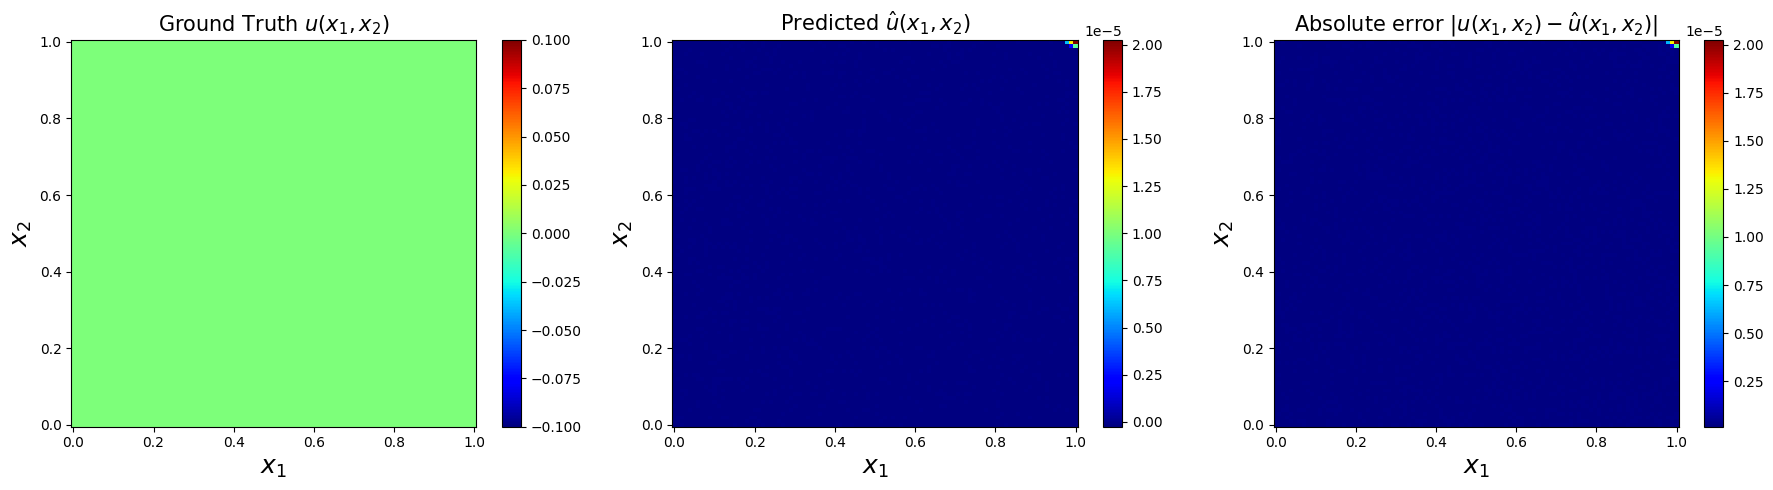

In [16]:
# Plot ground truth, predicted solution, and error
solutionplot(u_pred, X_u_train, u_train, x_1, x_2)

TypeError: Input z must be 2D, not 1D

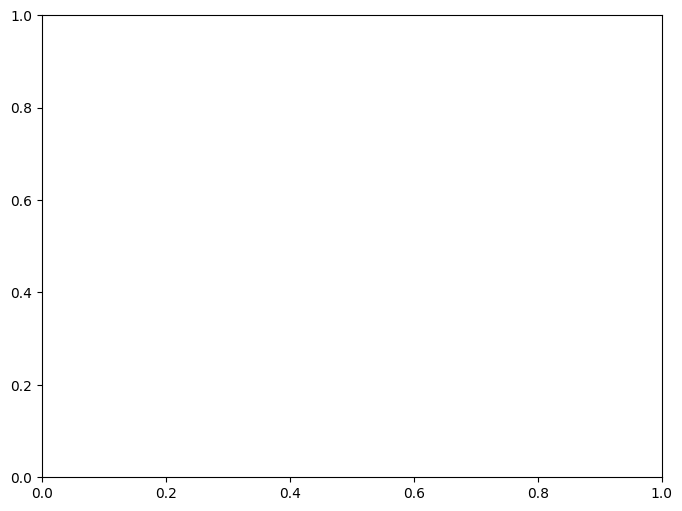

In [17]:
# Return lowest energy ground state (u as a vector and lambda as a scalar) and plot values
plot_ground_state_2d(model, X_u_train[:, 0], X_u_train[:, 1])

In [ ]:
plot_ground_state_3d(model, X_u_train[:, 0], X_u_train[:, 1])